# Evaluating structures with multiple components from STL files

This notebook outlines the process that seems best for importing STL assemblies containing multiple box/brick objects. It outlines a class structure that can encapsulate the necessary functions and bridge the gap between STL object and Warp conductor/dielectric object.

**Issues:**

1. `stl.mesh.save()` doesn't seem to work properly when saving in ascii format...
2. It's unclear how we want to pass along meta-data. Currently, the import/export functions only retain the geometry of the object. Therefore, when translating the `Box` command to Warp, the voltage or permittivity of the object will need to be specified separately.

Nathan Cook
1/10/2018

In [56]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
from __future__ import division
import sys
del sys.argv[1:] #  Necessry to run 'from warp import *' in IPython notebook without conflict.
from warp import * 
from warp.run_modes.egun_like import gun, gunppzx #needed for egun script
import numpy as np
import matplotlib.pyplot as plt
import os
#from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import h5py
from re import findall
from scipy.special import erfinv
from datetime import datetime


import rswarp
from warp.data_dumping.openpmd_diag import ParticleDiagnostic
from rswarp.diagnostics import FieldDiagnostic
from rswarp.diagnostics import ConductorDiagnostics
from rswarp.utilities.file_utils import cleanupPrevious
from rswarp.utilities.file_utils import readparticles
from rswarp.utilities.file_utils import loadparticlefiles
from rswarp.cathode import sources
from rswarp.cathode import injectors
from warp.particles.singleparticle import TraceParticle


#STL imports
import stl
from stl import mesh
from mpl_toolkits import mplot3d
%matplotlib inline

# Constants imports
from scipy.constants import e, m_e, c, k
from scipy.constants import c as clight
kb_eV = 8.6173324e-5 #Bolztmann constant in eV/K
kb_J = k #Boltzmann constant in J/K
m = m_e

## Functions for basic creation and plotting of test objects

Before delving into the class development and testing, we'll define some basic functions for manipulating STL objects in Python.

In [96]:
def make_brick(x_w,y_w,z_l,x_offset,y_offset,z_offset):
    '''
    Construct an STL representation of a box object using Warp's required inputs. 
    
    Arguments:
        x_w        (float) : x-length (m)
        y_w        (float) : y-length (m)
        z_w        (float) : z-length (m)
        x_offset   (float) : x-coordinate of centroid (m)
        y_offset   (float) : y-coordinate of centroid (m)
        z_offset   (float) : z-coordinate of centroid (m)
    
    '''
    
    
    W_traslation = [x_offset, y_offset, z_offset]

    #create the cube centered at the origin
    W_vertices = 1.0*np.array([\
        [-1, -1, -1],
        [+1, -1, -1],
        [+1, +1, -1],
        [-1, +1, -1],
        [-1, -1, +1],
        [+1, -1, +1],
        [+1, +1, +1],
        [-1, +1, +1]])

    #Apply lengths
    W_vertices[:,0] = 0.5*x_w*W_vertices[:,0]
    W_vertices[:,1] = 0.5*y_w*W_vertices[:,1]
    W_vertices[:,2] = 0.5*z_l*W_vertices[:,2]

    # Define the 12 triangles composing the box
    W_faces = np.array([\
        [0,3,1],
        [1,3,2],
        [0,4,7],
        [0,7,3],
        [4,5,6],
        [4,6,7],
        [5,1,2],
        [5,2,6],
        [2,3,6],
        [3,7,6],
        [0,1,5],
        [0,5,4]])

    # Create the mesh
    W_cond = mesh.Mesh(np.zeros(W_faces.shape[0], dtype=mesh.Mesh.dtype))
    for i, f in enumerate(W_faces):
        for j in range(3):
            W_cond.vectors[i][j] = W_vertices[f[j],:]

    W_cond.translate(W_traslation)
    
    return W_cond

def find_mins_maxs(points):
    """
    Find the minimum and maximum cooridnates of an STL mesh object in each plane.
    
    Adapted to pass points arrays in rather than the full mesh object.
    
    """
    minx = maxx = miny = maxy = minz = maxz = None
    for p in points:
        # p contains (x, y, z)
        if minx is None:
            minx = p[stl.Dimension.X]
            maxx = p[stl.Dimension.X]
            miny = p[stl.Dimension.Y]
            maxy = p[stl.Dimension.Y]
            minz = p[stl.Dimension.Z]
            maxz = p[stl.Dimension.Z]
        else:
            maxx = max(p[stl.Dimension.X], maxx)
            minx = min(p[stl.Dimension.X], minx)
            maxy = max(p[stl.Dimension.Y], maxy)
            miny = min(p[stl.Dimension.Y], miny)
            maxz = max(p[stl.Dimension.Z], maxz)
            minz = min(p[stl.Dimension.Z], minz)
            
    return minx, maxx, miny, maxy, minz, maxz

def plot_obj(obj):
    '''Simple 3D plotting tool for a collection of vectors
    
    Arguments:
        obj (stl.mesh) : mesh object from an STL construction or file
    
    '''
    
    # Create a new plot
    fig = plt.figure()
    ax = mplot3d.Axes3D(fig)

    # Add the vectors to the plot
    ax.add_collection3d(mplot3d.art3d.Poly3DCollection(obj.vectors))

    # Auto scale to the mesh size
    scale = obj.points.flatten(-1)
    ax.auto_scale_xyz(scale, scale, scale)
    
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    
    #get maxima and adjust domain accordingly
    minx, maxx, miny, maxy, minz, maxz = find_mins_maxs(obj)
    
    ax.set_xlim([minx,maxx])
    ax.set_ylim([miny,maxy])
    ax.set_zlim([minz,maxz])
    
    #adjust tick labels for scientific notation
    ax.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
    
    # Show the plot to the screen
    plt.show()

### A simple example: constructing a dumbbell

In [107]:
x_w = 0.25e-6
z_l = 0.5e-6
y_w = 0.25e-6
z_offset = 0.5e-6
y_offset = 0
x_offset = 0

#Make sep
W_1 = make_brick(x_w,y_w,z_l,x_offset,y_offset,z_offset)
W_2 = make_brick(x_w/2.,y_w/2.,z_l,x_offset,y_offset,z_offset+z_l)
W_3 = make_brick(x_w,y_w,z_l,x_offset,y_offset,z_offset+2.*z_l) 

#Now combine
dumbbell= mesh.Mesh(numpy.concatenate([W_1.data, W_2.data, W_3.data]))
#Save to file
dumbbell.save('dumbbell.stl')#, mode=stl.Mode.ASCII) 

#Save a simpler 2 block configuration
twoblocks = mesh.Mesh(numpy.concatenate([W_1.data, W_2.data]))
twoblocks.save('twoblocks.stl')#, mode=stl.Mode.ASCII)

/Users/ncook/.virtualenvs/rswarp_env/lib/python2.7/site-packages/ipykernel_launcher.py:100: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead


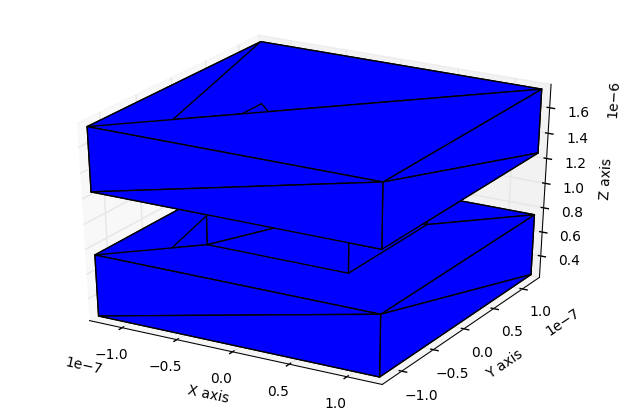

In [97]:
#plot the dumbbell
plot_obj(dumbbell)

### Importing objects and translating them to Warp

Idea here is to be able to convert each element of a multi-brick STL assembly into the appropriate Warp conductor object. This requires the following basic steps:

1. Determine how many elements there are
2. Separate points into temporary arrays
3. Use those temporary arrays to determine the min/max coordinates in all planes
4. Use those min/max coordinates to construct the Warp object!

In [140]:
round_sig = lambda f,n: float(('%.' + str(n) + 'e') % f)
#Rounds a floating point number to `n` significant digits
#Necessary due to small small discrepancies in the import/export and converstion of STL geometries
#In most cases, I've fixed the number of significant digits at 4.

def import_STL(filename):
    full_mesh = mesh.Mesh.from_file(filename)
    
    assert full_mesh.vectors.shape[0]%12 == 0, \
        'Number of triangles should be a multiple of 12'
    
    num_boxes = int(full_mesh.vectors.shape[0]/12.)
    boxes = []
    
    for index in range(num_boxes):
        #grab indices for slicing
        left = 12*index
        right = 12*(index+1)
        
        #get lengths
        minx, maxx, miny, maxy, minz, maxz = find_mins_maxs(full_mesh.points[left:right])
        x_len = round_sig(maxx - minx, 4)
        y_len = round_sig(maxy - miny, 4)
        z_len = round_sig(maxz - minz, 4)
        
        #get center
        x_cen = round_sig(0.5*(maxx+minx),4)
        y_cen = round_sig(0.5*(maxy+miny),4)
        z_cen = round_sig(0.5*(maxz+minz),4)
        
        #We now have the input values needed to reconstruct a Warp object or create a new STL object.
        boxes.append([x_len,y_len,z_len,x_cen,y_cen,z_cen])
        
    return boxes

In [141]:
#Try importing the dumbbell
import_STL('dumbbell.stl')

[[2.5e-07, 2.5e-07, 5e-07, 0.0, 0.0, 5e-07],
 [1.25e-07, 1.25e-07, 5e-07, 0.0, 0.0, 1e-06],
 [2.5e-07, 2.5e-07, 5e-07, 0.0, 0.0, 1.5e-06]]

This seems to work!

### Now look at Nick's COMSOL grid

In [144]:
#Load the STL files
grid_mesh = mesh.Mesh.from_file('COMSOL/TEC_ComsolGridExport1.stl') 

/Users/ncook/.virtualenvs/rswarp_env/lib/python2.7/site-packages/ipykernel_launcher.py:100: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead


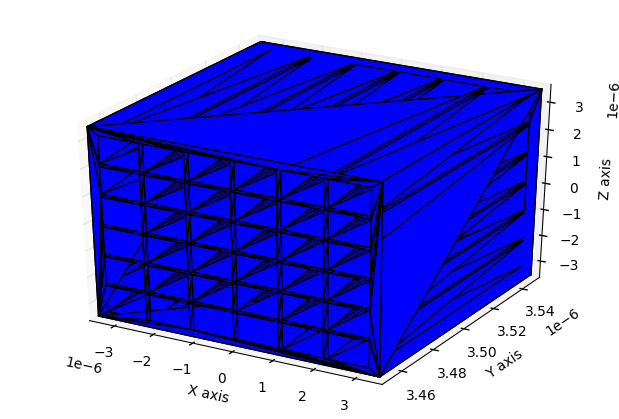

In [145]:
plot_obj(grid_mesh)

Does the import STL work? It looks promising.

In [146]:
import_STL('COMSOL/TEC_ComsolGridExport1.stl') 

[[7e-06, 0.0, 7e-06, 0.0, 3.45e-06, 0.0],
 [7e-06, 0.0, 7e-06, 0.0, 3.45e-06, 0.0],
 [1.35e-06, 0.0, 6.75e-06, -2.825e-06, 3.45e-06, 1.25e-07],
 [3.45e-06, 0.0, 6.75e-06, -1.775e-06, 3.45e-06, 1.25e-07],
 [1.25e-06, 0.0, 4.55e-06, -2.875e-06, 3.45e-06, 1.225e-06],
 [7e-06, 0.0, 7e-06, 0.0, 3.45e-06, 0.0],
 [7e-06, 0.0, 7e-06, 0.0, 3.45e-06, 0.0],
 [0.0, 0.0, 3.3e-06, -1.15e-06, 3.45e-06, 6e-07],
 [7e-06, 0.0, 7e-06, 0.0, 3.45e-06, 0.0],
 [4.55e-06, 0.0, 6.75e-06, 1.225e-06, 3.45e-06, -1.25e-07],
 [0.0, 0.0, 3.3e-06, -5e-08, 3.45e-06, 6e-07],
 [3.3e-06, 0.0, 5.5e-06, 1.6e-06, 3.45e-06, 5e-07],
 [3.45e-06, 0.0, 7e-06, 1.775e-06, 3.45e-06, 0.0],
 [0.0, 0.0, 3.3e-06, 1.05e-06, 3.45e-06, 6e-07],
 [2.45e-06, 0.0, 5.75e-06, 2.275e-06, 3.45e-06, 6.25e-07],
 [2.35e-06, 0.0, 6.75e-06, 2.325e-06, 3.45e-06, 1.25e-07],
 [0.0, 0.0, 3.3e-06, 2.15e-06, 3.45e-06, 6e-07],
 [1e-07, 0.0, 6.5e-06, 2.2e-06, 3.45e-06, 0.0],
 [7e-06, 1e-07, 7e-06, 0.0, 3.5e-06, 0.0],
 [7e-06, 0.0, 7e-06, 0.0, 3.55e-06, 0.0],


## Python class for managing STL-Warp interchange

For the time being, this class will only manage rectilinear objects (those which would conform to the Warp grid). It will import/export STL (binary) files and permit creation of Warp objects with member variables. The class will also keep track of other physical properties, but these won't be managed in the STL file.

The geometry/physical data needed (class variables):

- x_w, y_w, z_l - sizes in x,y,z in m
- x_offset,y_offset,z_offset - coordinates of "center" in m 
- (not for import/export) - Voltage, permittivity

The functions needed:

- `import_STL()` - import the STL file to the class object and construct a list of solids from it.
- `create_box()` - create a box object for Warp. May be overkill to further wrap this function.
- `extract_box()` - extract a box object from the Warp grid and/or from Sirepo interface... (this can be done as a precursor to the export)
- `export_STL()` - export the objects to STL

Supporting functions:

- `make_brick()` 
- `find_mins_maxs()`
- `plot_obj()`

In [147]:
class WarpSTL(object):
    """
    Class for constructing STL geometries commensurate with Warp's conductor and dielectric handles. The class
    describes functions for storing relevant data, and importing/exporting from binary .STL file formats. The 
    current implementation assumes the passing of rectilinear structures, those described by 6 faces and 12 vectors.
    Import and export functions are supported by the `numpy-stl` package (http://pythonhosted.org/numpy-stl/).
    
    
    No arguments are passed to the constructor. Users must import, or otherwise define an object from within.
    The object maintains a dictionary of STL and corresponding Warp objects. That is, every time an object is
    created or imported in one format, it's duplicated in the corresponding format and both entries are added
    to their format-specific dictionaries with the same key.
    
    
    """
    
    
    def __init__(self):
        
        self.stl_dict = {} #dictionary of STL objects
        self.warp_dict = {} #dictionary of Warp conductors/dielectrics
        self.current = None #current object
        
        
    def create_box(x_w,y_w,z_l,x_offset,y_offset,z_offset, name = 'box'):
        
        '''Create a rectilinear object and its representation in both Warp and STL'''
        
        #Add the box to the dictionary of Warp objects
        if name not in self.warp_dict.keys():
            self.warp_dict[name] = [x_w,y_w,z_l,x_offset,y_offset,z_offset]
        else:
            box_num = len(len(warp_dict.keys()))
            box_key = 'box_' + box_num
            self.warp_dict[box_key] = [x_w,y_w,z_l,x_offset,y_offset,z_offset]
        
        #Now construct the STL mesh
        traslation = [x_offset, y_offset, z_offset]

        #create the cube centered at the origin
        vertices = 1.0*np.array([\
            [-1, -1, -1],
            [+1, -1, -1],
            [+1, +1, -1],
            [-1, +1, -1],
            [-1, -1, +1],
            [+1, -1, +1],
            [+1, +1, +1],
            [-1, +1, +1]])

        #Apply lengths
        vertices[:,0] = 0.5*x_w*vertices[:,0]
        vertices[:,1] = 0.5*y_w*vertices[:,1]
        vertices[:,2] = 0.5*z_l*vertices[:,2]

        # Define the 12 faces of the triangles constraining the box's surface
        faces = np.array([\
            [0,3,1],
            [1,3,2],
            [0,4,7],
            [0,7,3],
            [4,5,6],
            [4,6,7],
            [5,1,2],
            [5,2,6],
            [2,3,6],
            [3,7,6],
            [0,1,5],
            [0,5,4]])

        # Create the box object
        box = mesh.Mesh(np.zeros(W_faces.shape[0], dtype=mesh.Mesh.dtype))
        for i, f in enumerate(faces):
            for j in range(3):
                box.vectors[i][j] = vertices[f[j],:]

        box.translate(traslation)
        
        #Add the STL mesh to the object dic
        if name not in self.stl_dict.keys():
            self.stl_dict[name] = box
        else:
            box_num = len(len(stl_dict.keys()))
            box_key = 'box_' + box_num
            self.stl_dict[box_key]
        
        self.current = box
    

    def import_STL(self,filename, style='binary'):
        '''Load and STL file and define '''
        if not style == 'binary':
            #Not yet implemented
            raise NotImplementedError("Non-binary STL file formats are not currently supported")
        else:            
            full_mesh = mesh.Mesh.from_file(filename)
    
        assert full_mesh.vectors.shape[0]%12 == 0, \
            'Number of triangles should be a multiple of 12'
    
        num_boxes = int(full_mesh.vectors.shape[0]/12.)
        boxes = []
    
        for index in range(num_boxes):
            #grab indices for slicing
            left = 12*index
            right = 12*(index+1)
        
            #get lengths
            minx, maxx, miny, maxy, minz, maxz = self.find_mins_maxs(full_mesh.points[left:right])
            x_len = round_sig(maxx - minx, 4)
            y_len = round_sig(maxy - miny, 4)
            z_len = round_sig(maxz - minz, 4)
        
            #get center
            x_cen = round_sig(0.5*(maxx+minx),4)
            y_cen = round_sig(0.5*(maxy+miny),4)
            z_cen = round_sig(0.5*(maxz+minz),4)
        
            #We now have the input values needed to reconstruct a Warp object or create a new STL object.
            box_num = len(self.warp_dict.keys())
            box_key = 'box_' + box_num
            self.warp_dict[box_key] = [x_len,y_len,z_len,x_cen,y_cen,z_cen]
            
            #Similarly store the STL object in the STL dictionary by taking the applicable chunk of data
            box_mesh = mesh.Mesh(full_mesh.data[left:right])
            self.stl_dict[box_key] = box_mesh
        
        return
            
    def export_STL(self,filename):
        """Export the current object to a binary STL file"""
        
        self.current.save(filename)
        
    def export_all(self,filename):
        """Export all objects to a binary STL file"""

	def find_mins_maxs(points):
	    """
	    Find the minimum and maximum cooridnates of an STL mesh object in each plane.
    
	    Adapted to pass points arrays in rather than the full mesh object.
    
	    """
	    minx = maxx = miny = maxy = minz = maxz = None
	    for p in points:
	        # p contains (x, y, z)
	        if minx is None:
	            minx = p[stl.Dimension.X]
	            maxx = p[stl.Dimension.X]
	            miny = p[stl.Dimension.Y]
	            maxy = p[stl.Dimension.Y]
	            minz = p[stl.Dimension.Z]
	            maxz = p[stl.Dimension.Z]
	        else:
	            maxx = max(p[stl.Dimension.X], maxx)
	            minx = min(p[stl.Dimension.X], minx)
	            maxy = max(p[stl.Dimension.Y], maxy)
	            miny = min(p[stl.Dimension.Y], miny)
	            maxz = max(p[stl.Dimension.Z], maxz)
	            minz = min(p[stl.Dimension.Z], minz)
            
	    return minx, maxx, miny, maxy, minz, maxz

	def plot_obj(obj):
	    '''Simple 3D plotting tool for a collection of vectors
    
	    Arguments:
	        obj (stl.mesh) : mesh object from an STL construction or file
    
	    '''
    
	    # Create a new plot
	    fig = plt.figure()
	    ax = mplot3d.Axes3D(fig)

	    # Add the vectors to the plot
	    ax.add_collection3d(mplot3d.art3d.Poly3DCollection(obj.vectors))

	    # Auto scale to the mesh size
	    scale = obj.points.flatten(-1)
	    ax.auto_scale_xyz(scale, scale, scale)
    
	    ax.set_xlabel('X axis')
	    ax.set_ylabel('Y axis')
	    ax.set_zlabel('Z axis')
    
	    #get maxima and adjust domain accordingly
	    minx, maxx, miny, maxy, minz, maxz = find_mins_maxs(obj)
    
	    ax.set_xlim([minx,maxx])
	    ax.set_ylim([miny,maxy])
	    ax.set_zlim([minz,maxz])
    
	    #adjust tick labels for scientific notation
	    ax.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
    
	    # Show the plot to the screen
	    plt.show()